# Movie Recommendations

The purpose of this notebook is to cluster the combination of ratings and tags of movie data to determine similar movies to recommend to users. This is similar to the Netflix algorithm. 

### 1. Load Datasets

In [65]:
import numpy as np
import pandas as pd

links = pd.read_csv("../data/links.csv")
movies = pd.read_csv("../data/movies.csv")
#shuffle movies
movies = movies.sample(frac=1, random_state = 1)
ratings = pd.read_csv("../data/ratings.csv")
tags = pd.read_csv("../data/tags.csv")
print(movies.head(5))
print(ratings.head(4))
print(tags.head(4))
print(links.head(4))

      movieId                            title                 genres
6514    53894                     Sicko (2007)      Documentary|Drama
619       784            Cable Guy, The (1996)        Comedy|Thriller
3818     5348          Hollywood Ending (2002)           Comedy|Drama
3530     4825  Swamp, The (Ciénaga, La) (2001)           Comedy|Drama
1225     1626           Fire Down Below (1997)  Action|Drama|Thriller
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0


There are quite a few ways we could combine the datasets. We can explore relationships between average user ratings and movies, associate tags with movies, etc. The IMDB data is of questionable value, so we likely won't use it.

### 2. Feature Engineering and Data Cleaning
The first step of our feature engineering will be to split the genres into their own columns, thereby one-hot encoding these. If there are grouped together, we would have to have exact matches to be meaningful (think of label encoding). Since we might want to recommend a movie that is both a thriller and a comedy to someone who watched an animation and a comedy, we want these genres to be separate.

In [66]:
#go through all the movies to and create a list of all possible genres

genres = set([])

for index, row in movies.iterrows():
    g = row['genres'].split('|')
    for i in g:
        genres.add(i)
        
print(genres)


#then add a column for each genre to the movies df, one hot encoding them
for i in genres:
    movies[i] = 0

print(movies.head(3))

{'Horror', 'Mystery', 'Crime', 'Film-Noir', 'IMAX', 'Fantasy', 'Romance', '(no genres listed)', 'Action', 'Sci-Fi', 'Documentary', 'Drama', 'Comedy', 'Musical', 'War', 'Western', 'Thriller', 'Animation', 'Children', 'Adventure'}
      movieId                    title             genres  Horror  Mystery  \
6514    53894             Sicko (2007)  Documentary|Drama       0        0   
619       784    Cable Guy, The (1996)    Comedy|Thriller       0        0   
3818     5348  Hollywood Ending (2002)       Comedy|Drama       0        0   

      Crime  Film-Noir  IMAX  Fantasy  Romance  ...  Documentary  Drama  \
6514      0          0     0        0        0  ...            0      0   
619       0          0     0        0        0  ...            0      0   
3818      0          0     0        0        0  ...            0      0   

      Comedy  Musical  War  Western  Thriller  Animation  Children  Adventure  
6514       0        0    0        0         0          0         0          0

In [67]:
#next go through all the rows and one hot encode the columns
for index, row in movies.iterrows():
    g = row['genres'].split('|') 
    for i in g:
        movies.at[index, i] = 1

#now drop the original genres column
movies.drop(columns=['genres'], inplace=True)
print(movies.head(3))

      movieId                    title  Horror  Mystery  Crime  Film-Noir  \
6514    53894             Sicko (2007)       0        0      0          0   
619       784    Cable Guy, The (1996)       0        0      0          0   
3818     5348  Hollywood Ending (2002)       0        0      0          0   

      IMAX  Fantasy  Romance  (no genres listed)  ...  Documentary  Drama  \
6514     0        0        0                   0  ...            1      1   
619      0        0        0                   0  ...            0      0   
3818     0        0        0                   0  ...            0      1   

      Comedy  Musical  War  Western  Thriller  Animation  Children  Adventure  
6514       0        0    0        0         0          0         0          0  
619        1        0    0        0         1          0         0          0  
3818       1        0    0        0         0          0         0          0  

[3 rows x 22 columns]


Next we will label encode the tags. There are many different ones, however there is some overlap. I considered using word2Vec, but decided that there wasn't enough context to make it meaningful. I may not use these because the true value would be added by adding meaning to the words. For instance, if we had three movies that were tagged "boring", we wouldn't want to recommend the other boring movies. Potentially, we could deduce this without NLP by looking at the rating a user gave a movie and then associating a tag as positive, negative or neutral. For example, if a user rated a movie < 3 and tagged it "boring", we could make an assumption that the tag "boring" is negative, then we wouldn't want to recommend movies that have that tag. While an interesting possibility, the implementation of this feature is outside of the scope of this project (at least with my current Python skills).

In [68]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(tags['tag'])

tags['tag'] = le.transform(tags['tag']) 
tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,936,1445714994
1,2,60756,231,1445714996
2,2,60756,1573,1445714992
3,2,89774,73,1445715207
4,2,89774,322,1445715200


Next let's add a column showing the average rating for each movie. This will add value by creating a single rating for a movie that we can tack on as a column to the movies dataframe. In general, people enjoy watching good movies, so having a high average rating would imply that more people would enjoy that movie. It is also important to consider the number of ratings a movie has. If Star Wars had an average rating of 1 out of 5, that wouldn't seem correct. But if we saw that there was only one rating total, then we conclude that it doesn't necessarily represent the opinion of the masses. The average rating will be considered more accurate if there is a higher rating count.

In [69]:
def getAverageRating(currMovie):
    isMovie = ratings['movieId'] == currMovie
    movieRating = ratings[isMovie]
    return movieRating['rating'].mean()

def getCount(currMovie):
    isMovie = ratings['movieId'] == currMovie
    movieRating = ratings[isMovie]
    return movieRating['rating'].count()

    
averageRating = movies['movieId'].map(lambda x: getAverageRating(x))
ratingCount = movies['movieId'].map(lambda x: getCount(x))

movies['averageRating'] = averageRating
movies['ratingCount'] = ratingCount
movies.head()

,movieId,title,Horror,Mystery,Crime,Film-Noir,IMAX,Fantasy,Romance,(no genres listed),...,Comedy,Musical,War,Western,Thriller,Animation,Children,Adventure,averageRating,ratingCount
6514,53894,Sicko (2007),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.714286,14
619,784,"Cable Guy, The (1996)",0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,2.805556,54
3818,5348,Hollywood Ending (2002),0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,4.000000,1
3530,4825,"Swamp, The (Ciénaga, La) (2001)",0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3.000000,1
1225,1626,Fire Down Below (1997),0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2.666667,3


Let's come up with a way to give more weight to the ratings with higher rating counts. We will do this by multiplying the rating for each movie by the rating count divided by the average rating count. We also can drop the rows that include NaN because there are only 18 of these, which is negligible. 

In [70]:
averageCount = movies['ratingCount'].mean()
movies['weightedRating'] = movies['averageRating'] * movies['ratingCount'] / averageCount
movies.sort_values(by=['weightedRating'], ascending = False, inplace = True)

print("Number of NaN rows in each column:")
print(movies.isna().sum())
movies.dropna(inplace=True)

movies.head()

Number of NaN rows in each column:
movieId                0
title                  0
Horror                 0
Mystery                0
Crime                  0
Film-Noir              0
IMAX                   0
Fantasy                0
Romance                0
(no genres listed)     0
Action                 0
Sci-Fi                 0
Documentary            0
Drama                  0
Comedy                 0
Musical                0
War                    0
Western                0
Thriller               0
Animation              0
Children               0
Adventure              0
averageRating         18
ratingCount            0
weightedRating        18
dtype: int64


,movieId,title,Horror,Mystery,Crime,Film-Noir,IMAX,Fantasy,Romance,(no genres listed),...,Musical,War,Western,Thriller,Animation,Children,Adventure,averageRating,ratingCount,weightedRating
277,318,"Shawshank Redemption, The (1994)",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4.429022,317,135.643699
314,356,Forrest Gump (1994),0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,4.164134,329,132.358880
257,296,Pulp Fiction (1994),0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,4.197068,307,124.484976
1939,2571,"Matrix, The (1999)",0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,4.192446,278,112.601660
510,593,"Silence of the Lambs, The (1991)",1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,4.161290,279,112.166905


We see here that the top-rated movies according to the weighting are, objectively, good movies. Therefore, this is a valid weighting calculation.

### 3. Models and Evaluation

Now that we have done a substantial amount of feature engineering, we can start trying some models. The first one will be a k-means clustering algorithm. We drop the weightedRating, rating count, and average rating for training because we would prefer to recommend good movies (with a higher rating). Just because someone watches a 1 star movies doesn't mean that should be our recommendation focus. These will reappear later. The final step is to determine how many clusters we should use for the KMeans model. To do this, we generate an elbow graph.

In [71]:
#drop movie title, movieID, average rating, and count
data = movies.drop(columns=['title', 'movieId', 'averageRating', 'ratingCount', 'weightedRating'])

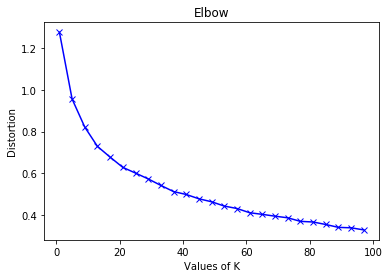

In [72]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np 
import matplotlib.pyplot as plt 

distortions = [] 
inertias = [] 
mapping1 = {}
mapping2 = {} 
K = range(1,100, 4) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(data) 
    kmeanModel.fit(data)     
      
    distortions.append(sum(np.min(cdist(data, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / data.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(data, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / data.shape[0] 
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('Elbow') 
plt.show() 

We select 24 as the elbow point, so will have 24 clusters.

In [73]:
numClusters = 24
kmeans = KMeans(n_clusters=numClusters, random_state=0).fit_predict(data)
data.head()

,Horror,Mystery,Crime,Film-Noir,IMAX,Fantasy,Romance,(no genres listed),Action,Sci-Fi,Documentary,Drama,Comedy,Musical,War,Western,Thriller,Animation,Children,Adventure
277,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
314,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0
257,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1939,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0
510,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


After training the KMeans model, we add the cluster each movie belongs to to a new column in the movies dataframe.

In [74]:
movies['predictionClusterKMEANS'] = pd.DataFrame(kmeans)
movies.head()

,movieId,title,Horror,Mystery,Crime,Film-Noir,IMAX,Fantasy,Romance,(no genres listed),...,War,Western,Thriller,Animation,Children,Adventure,averageRating,ratingCount,weightedRating,predictionClusterKMEANS
277,318,"Shawshank Redemption, The (1994)",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,4.429022,317,135.643699,10.0
314,356,Forrest Gump (1994),0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,4.164134,329,132.358880,0.0
257,296,Pulp Fiction (1994),0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,4.197068,307,124.484976,4.0
1939,2571,"Matrix, The (1999)",0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,4.192446,278,112.601660,17.0
510,593,"Silence of the Lambs, The (1991)",1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,4.161290,279,112.166905,22.0


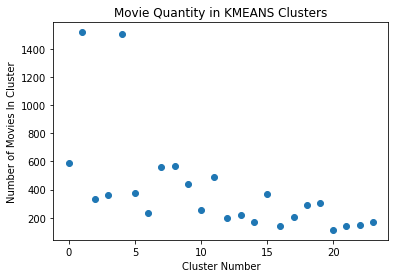

In [75]:
#visualize the clusters
dict = {}

for i, row in movies.iterrows():    
    dict[row['predictionClusterKMEANS']] = dict.get(row['predictionClusterKMEANS'], 0) + 1
    
z = pd.DataFrame(list(dict.items())).iloc[0:numClusters]
x = z[0]
y = z[1]

plt.scatter(x, y) 
plt.xlabel('Cluster Number') 
plt.ylabel('Number of Movies In Cluster') 
plt.title('Movie Quantity in KMEANS Clusters') 
plt.show() 

We observe that in general, there is a fairly even distribution of movies accross the clusters, with two outliers. One reason for this is that we could have a couple genres that have many more movies than the rest. Now that we have a trained model, we can generate some recommendations for a few examples. Let's look at Percy Jackson.

In [76]:
PercyJackson = 74530
PercyJacksonCluster = movies[movies['movieId'] == PercyJackson]['predictionClusterKMEANS'].iloc[0]

similarMoviesToPercyJackson = movies[movies['predictionClusterKMEANS'] == PercyJacksonCluster].sort_values(by='weightedRating', ascending = False)
similarMoviesToPercyJackson.head(10)

,movieId,title,Horror,Mystery,Crime,Film-Noir,IMAX,Fantasy,Romance,(no genres listed),...,War,Western,Thriller,Animation,Children,Adventure,averageRating,ratingCount,weightedRating,predictionClusterKMEANS
257,296,Pulp Fiction (1994),0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,4.197068,307,124.484976,4.0
659,858,"Godfather, The (1972)",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,4.289062,192,79.560246,4.0
4137,5952,"Lord of the Rings: The Two Towers, The (2002)",0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,4.021277,188,73.038915,4.0
793,1036,Die Hard (1988),0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,3.862069,145,54.102900,4.0
512,595,Beauty and the Beast (1991),0,0,0,0,1,1,1,0,...,0,0,0,1,1,0,3.770548,146,53.185083,4.0
922,1221,"Godfather: Part II, The (1974)",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,4.259690,129,53.088470,4.0
3622,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,4.183333,120,48.499385,4.0
4159,5989,Catch Me If You Can (2002),0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,3.921739,115,43.572157,4.0
3562,4878,Donnie Darko (2001),0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,3.981651,109,41.929747,4.0
6772,60069,WALL·E (2008),0,0,0,0,0,0,1,0,...,0,0,0,1,1,1,4.057692,104,40.770399,4.0


Observe the above movies that were recommended as being similar to Percy Jackson, an action packed story taking place in the world of greek mythology. Mission Impossible is also an action focused movie, the Hobbit is an adventure, as are many of the other movies listed in the top 10, sorted by weightedRating in the Percy Jackson cluster.

Let's try a different model now: the DBSCAN. We will also add the resulting clusters as a new column for DBSCAN.

In [77]:
from sklearn.cluster import DBSCAN
db = DBSCAN().fit_predict(data)
print(db)
movies['predictionClusterDBSCAN'] = pd.DataFrame(db)
movies.head()

[ 0  1  2 ... 92 55 34]


,movieId,title,Horror,Mystery,Crime,Film-Noir,IMAX,Fantasy,Romance,(no genres listed),...,Western,Thriller,Animation,Children,Adventure,averageRating,ratingCount,weightedRating,predictionClusterKMEANS,predictionClusterDBSCAN
277,318,"Shawshank Redemption, The (1994)",0,0,1,0,0,0,0,0,...,0,0,0,0,0,4.429022,317,135.643699,10.0,-1.0
314,356,Forrest Gump (1994),0,0,0,0,0,0,1,0,...,0,0,0,0,0,4.164134,329,132.358880,0.0,97.0
257,296,Pulp Fiction (1994),0,0,1,0,0,0,0,0,...,0,1,0,0,0,4.197068,307,124.484976,4.0,78.0
1939,2571,"Matrix, The (1999)",0,0,0,0,0,0,0,0,...,0,1,0,0,0,4.192446,278,112.601660,17.0,-1.0
510,593,"Silence of the Lambs, The (1991)",1,0,1,0,0,0,0,0,...,0,1,0,0,0,4.161290,279,112.166905,22.0,21.0


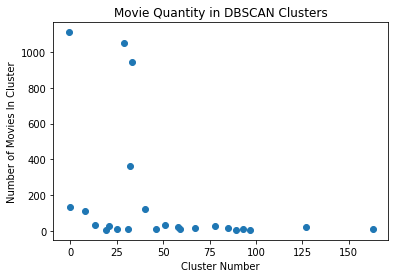

In [78]:
#visualize the clusters
dict = {}

for i, row in movies.iterrows():    
    dict[row['predictionClusterDBSCAN']] = dict.get(row['predictionClusterDBSCAN'], 0) + 1
    
z = pd.DataFrame(list(dict.items())).iloc[0:numClusters]
x = z[0]
y = z[1]

plt.scatter(x, y) 
plt.xlabel('Cluster Number') 
plt.ylabel('Number of Movies In Cluster') 
plt.title('Movie Quantity in DBSCAN Clusters') 
plt.show() 

The distribution of movies across clusters here is also fairly consistent, but there are more outliers: three or four outliers; potentially these are for the same reason described for the KMEANS model.

In [79]:
PercyJackson = 74530
PercyJacksonCluster = movies[movies['movieId'] == PercyJackson]['predictionClusterDBSCAN'].iloc[0]

similarMoviesToPercyJackson = movies[movies['predictionClusterDBSCAN'] == PercyJacksonCluster].sort_values(by='weightedRating', ascending = False)
similarMoviesToPercyJackson.head(10)

,movieId,title,Horror,Mystery,Crime,Film-Noir,IMAX,Fantasy,Romance,(no genres listed),...,Western,Thriller,Animation,Children,Adventure,averageRating,ratingCount,weightedRating,predictionClusterKMEANS,predictionClusterDBSCAN
1073,1393,Jerry Maguire (1996),0,0,0,0,0,0,1,0,...,0,0,0,0,0,3.594118,85,29.515064,4.0,82.0
1209,1608,Air Force One (1997),0,0,0,0,0,0,0,0,...,0,1,0,0,0,3.344828,58,18.742790,4.0,82.0
2394,3176,"Talented Mr. Ripley, The (1999)",0,1,0,0,0,0,0,0,...,0,1,0,0,0,3.336735,49,15.796114,4.0,82.0
2828,3785,Scary Movie (2000),1,0,0,0,0,0,0,0,...,0,0,0,0,0,2.920000,50,14.105399,4.0,82.0
2657,3555,U-571 (2000),0,0,0,0,0,0,0,0,...,0,1,0,0,0,3.424242,33,10.917192,4.0,82.0
3129,4211,Reversal of Fortune (1990),0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.750000,6,2.173777,4.0,82.0
4326,6322,Confidence (2003),0,0,1,0,0,0,0,0,...,0,1,0,0,0,2.833333,6,1.642409,4.0,82.0
7261,74530,Percy Jackson & the Olympians: The Lightning T...,0,0,0,0,0,1,0,0,...,0,0,0,0,1,2.357143,7,1.594103,4.0,82.0
1718,2310,"Mighty, The (1998)",0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.666667,3,1.062736,4.0,82.0
1134,1484,"Daytrippers, The (1996)",0,1,0,0,0,0,1,0,...,0,0,0,0,0,3.666667,3,1.062736,4.0,82.0


Observe that there is some overlap with the DBSCAN and KMEANS models. This is to be expected because the data passed in was identical. Unfortunately, my knowledge of movies is severly lacking so I am unable to draw conclusions about the similarities of most these movies, beyond a top-level google search.

Finally, let's give some recommendations for a different type of movie - a kid's movie: Tooth Fairy

In [80]:
ToothFairy = 74698
ToothFairyCluster = movies[movies['movieId'] == ToothFairy]['predictionClusterDBSCAN'].iloc[0]

similarMoviesToToothFairy = movies[movies['predictionClusterDBSCAN'] == ToothFairyCluster].sort_values(by='weightedRating', ascending = False)
similarMoviesToToothFairy.head(10)

,movieId,title,Horror,Mystery,Crime,Film-Noir,IMAX,Fantasy,Romance,(no genres listed),...,Western,Thriller,Animation,Children,Adventure,averageRating,ratingCount,weightedRating,predictionClusterKMEANS,predictionClusterDBSCAN
1559,2096,Sleeping Beauty (1959),0,0,0,0,0,0,0,0,...,0,0,1,1,0,3.409091,22,7.245924,4.0,193.0
2381,3159,Fantasia 2000 (1999),0,0,0,0,1,0,0,0,...,0,0,1,1,0,3.833333,15,5.555208,4.0,193.0
5010,7757,Jason and the Argonauts (1963),0,0,0,0,0,1,0,0,...,0,0,0,0,1,3.500000,6,2.028859,4.0,193.0
8728,127096,Project Almanac (2015),0,0,0,0,0,0,0,0,...,0,1,0,0,0,3.750000,4,1.449185,4.0,193.0
5980,36509,"Cave, The (2005)",1,1,0,0,0,0,0,0,...,0,1,0,0,1,2.666667,3,0.772899,4.0,193.0
7274,74698,Tooth Fairy (2010),0,0,0,0,0,1,0,0,...,0,0,0,0,0,2.166667,3,0.627980,4.0,193.0
3405,4632,"Package, The (1989)",0,0,0,0,0,0,0,0,...,0,1,0,0,0,3.000000,2,0.579674,4.0,193.0
7097,70451,Max Manus (2008),0,0,0,0,0,0,0,0,...,0,0,0,0,0,5.000000,1,0.483062,4.0,193.0
6164,44511,Unknown White Male (2005),0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.500000,1,0.338143,4.0,193.0
6882,63033,Blindness (2008),0,1,0,0,0,0,1,0,...,0,1,0,0,0,3.500000,1,0.338143,4.0,193.0


Here we see several children movies, such as Sleeping Beuty and The Package. However, one area of concern is in testing, some children movies recommended movies rated R. A common-sense "safety-check" could be to only recommend other movies of an equal or more accessible rating.

### 4. Conclusion
In this notebook, we generated models to provide recommendations of similar movies, given a movie. To recap, the use case could be if a streaming video service user finishes the movie The Incredibles, we could plug in The Incredibles data and receive a list of similar movies, sorted by average rating. As can be observed, the primary feature these models are trained on are the genres, then they are sorted by average rating in their resulting clusters. Extensions could include adding the tags as were described in section 2 of this notebook, looking at how individual users rated each movie and make the model input user AND movie, thereby increasing the level of recommendation personalization, and/or adding additional requirements to the cluster results (ie the age rating "safety-check" described above). However, our models generated meaningful results and could serve as a baseline for future recommendation engines.